In [32]:
import xarray as xr
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np

In [33]:
swb1_dir = '../swb1/'
swb_dir = '../swb2/'

# suppress exponential notation in plotting format
plt.rcParams['axes.formatter.useoffset'] = False
%matplotlib inline

In [34]:
comparison_cell_dict = {'Deciduous_forest':['96','44','553927','459454'],
                        'Evergreen_forest':['128','65','556791','457569'],
                        'Potato_field':['177','202','561167','445224'],
#                        'Rye':['9','277','546094','438492'],
                        'Corn':['115','319','555602','434644']}
#                        'Winter_wheat':['254','56','568129','458340'],
#                        'Sugar_beets': ['283','203','570741','445112']}

soil_variable_pairs = {1: ['potential_recharge','net_infiltration'],
                       2: ['ref_et0','reference_ET0'],
                       3: ['soil_storage','soil_storage'],
                       4: ['interception','interception'],
                       5: ['irrigation','irrigation'],
                       6: ['bare_soil_evap','bare_soil_evap'],
                       7: ['kcb','crop_coefficient_kcb'],
                       8: ['current_rooting_depth','current_rooting_depth'],
                       9: ['plant_stress_coef_ks','plant_stress_coef_ks'],
                      10: ['total_available_water','total_available_water'],
                      11: ['readily_available_water','readily_available_water'],
                      12: ['evap_reduction_coef_kr','evap_reduction_coef_kr'], 
                      13: ['surf_evap_coef_ke','surf_evap_coef_ke'],
                      14: ['snowmelt','snowmelt'],
                      15: ['snow_cover','snow_storage'],
                      16: ['runoff','runoff'],
                      17: ['crop_etc','crop_etc'],
                      18: ['gross_precip','gross_precip']}

precip_variable_pairs = {1: ['potential_recharge','net_infiltration'],
                       2: ['soil_storage','soil_storage'],
                       3: ['interception','interception'],
                       4: ['irrigation','irrigation'],
                       5: ['snowmelt','snowmelt'],
                       6: ['net_rainfall','net_rainfall'],  
                       7: ['snow_cover','snow_storage'],
                       8: ['runoff','runoff']}

atmos_variable_pairs = {1: ['tmin','tmin'],
                        2: ['tmax','tmax'],
                        3: ['tmean','tmean'],
                        4: ['snow_cover','snow_storage']}


landuse_codes = {141:'Deciduous forest',
                 142:'Evergreen forest',
                  43:'Potato'}

In [35]:
def filter_nan(s,o):
    """
    this functions removed the data  from simulated and observed data
    whereever the observed data contains nan
    
    this is used by all other functions, otherwise they will produce nan as 
    output
    """
    if np.sum(~np.isnan(s*o))>=1:
        data = np.array([s,o])
        data = np.transpose(data)
        data = data[~np.isnan(data).any(1)]
        s = data[:,0]
        o = data[:,1]
    return s, o

In [36]:
def bias(s,o):
    """
    Bias
    input:
        s: simulated
        o: observed
    output:
        bias: bias
    """
    s,o = filter_nan(s,o)
    return np.mean(s-o)

def NS(s,o):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    s,o = filter_nan(s,o)
    return 1 - sum((s-o)**2)/sum((o-np.mean(o)+1.0e-10)**2)

In [37]:
def read_swb1_csv( colnum, rownum ):
    filename = 'SWB_variable_values__col_' + colnum + '__row_' + rownum + '.csv'
    df = pd.read_csv(swb1_dir + filename, skipinitialspace=True,index_col=False)
    df.reindex()
    df = df.assign(date=pd.to_datetime(df[['year','month','day']]))
    return df

In [38]:
def read_swb2_csv( colnum, rownum, xcoord, ycoord ):
    filename = 'SWB2_variable_values__col_' + colnum + '__row_' + rownum + '__x_' + xcoord + '__y_' + ycoord + '.csv'
    df = pd.read_csv(swb_dir + filename, skipinitialspace=True,index_col=False)
    df.reindex()
    df = df.assign(date=pd.to_datetime(df[['year','month','day']]))
    return df

In [39]:
def create_joined_subset(swb1_df, swb2_df, swb1_colname, swb2_colname):
    swb1_ss = swb1_df.filter(['date', swb1_colname]) 
    swb2_ss = swb2_df.filter(['date', swb2_colname]) 
    comparison_df = pd.merge(swb1_ss,
                             swb2_ss,
                             left_on=swb1_ss.date, 
                             right_on=swb2_ss.date).drop(columns=['date_y'])
    comparison_df.columns=["date", "swb1_"+swb1_colname, "swb2_"+swb2_colname]
    return(comparison_df)

In [40]:
def make_plots( swb1_daily, swb2_daily, description ):
    for key, value in variable_pairs.items():
        swb1_fieldname = value[0]
        swb2_fieldname = value[1]
        print('creating joined subset... swb1 var=', swb1_fieldname, '   swb2 var=', swb2_fieldname)
        cc = create_joined_subset(swb1_daily, swb2_daily, swb1_fieldname, swb2_fieldname)
        ns = NS(cc.iloc[:,1],cc.iloc[:,2])
        if cc.count()[0] > 0 and ns < 0.99:
    #        slope, intercept, r_value, p_value, std_err = stats.linregress(cc.iloc[:,1], cc.iloc[:,2])
    #            if( slope > 0.0 and r_value < 0.9 ):
            lu_code = swb2_daily.landuse_code[0]
            lu_desc = landuse_codes.get(lu_code)
            title_txt = swb2_fieldname + ":  " + str(lu_code) + " - " + description + "  NS=",str(ns)
            fig, axes = plt.subplots(1,2,figsize=(17,12))
            fig.constrained_layout=True
            fig.suptitle(title_txt)
            maxx = np.nanmax(cc.iloc[:,2])
            minx = np.nanmin(cc.iloc[:,2])
            axes[0].plot(cc.iloc[:,1].values,cc.iloc[:,2],"+")
            axes[0].plot([minx,maxx],[minx,maxx],"r-")
            axes[0].set_xlabel('SWB1: ' + swb1_fieldname)
            axes[0].set_ylabel('SWB2: ' + swb2_fieldname)
            axes[1].plot(cc.iloc[:,0].values,cc.iloc[:,1].values,label='SWB1: ' + swb1_fieldname)
            axes[1].plot(cc.iloc[:,0].values,cc.iloc[:,2].values,label='SWB2: ' + swb2_fieldname)
            axes[1].legend()
            table(axes[1], np.round(cc.head(n=6), 5), colWidths=[0.2, 0.2, 0.2],loc='top',bbox=[0.1, -0.25, 0.8, 0.15])

Deciduous_forest ['96', '44', '553927', '459454']
creating joined subset... swb1 var= potential_recharge    swb2 var= net_infiltration
creating joined subset... swb1 var= ref_et0    swb2 var= reference_ET0
creating joined subset... swb1 var= soil_storage    swb2 var= soil_storage
creating joined subset... swb1 var= interception    swb2 var= interception
creating joined subset... swb1 var= irrigation    swb2 var= irrigation
creating joined subset... swb1 var= bare_soil_evap    swb2 var= bare_soil_evap
creating joined subset... swb1 var= kcb    swb2 var= crop_coefficient_kcb
creating joined subset... swb1 var= current_rooting_depth    swb2 var= current_rooting_depth
creating joined subset... swb1 var= plant_stress_coef_ks    swb2 var= plant_stress_coef_ks
creating joined subset... swb1 var= total_available_water    swb2 var= total_available_water
creating joined subset... swb1 var= readily_available_water    swb2 var= readily_available_water
creating joined subset... swb1 var= evap_reduc

/Users/smwesten/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


creating joined subset... swb1 var= runoff    swb2 var= runoff
creating joined subset... swb1 var= crop_etc    swb2 var= crop_etc
creating joined subset... swb1 var= gross_precip    swb2 var= gross_precip
Corn ['115', '319', '555602', '434644']
creating joined subset... swb1 var= potential_recharge    swb2 var= net_infiltration
creating joined subset... swb1 var= ref_et0    swb2 var= reference_ET0
creating joined subset... swb1 var= soil_storage    swb2 var= soil_storage
creating joined subset... swb1 var= interception    swb2 var= interception
creating joined subset... swb1 var= irrigation    swb2 var= irrigation
creating joined subset... swb1 var= bare_soil_evap    swb2 var= bare_soil_evap
creating joined subset... swb1 var= kcb    swb2 var= crop_coefficient_kcb
creating joined subset... swb1 var= current_rooting_depth    swb2 var= current_rooting_depth
creating joined subset... swb1 var= plant_stress_coef_ks    swb2 var= plant_stress_coef_ks
creating joined subset... swb1 var= total

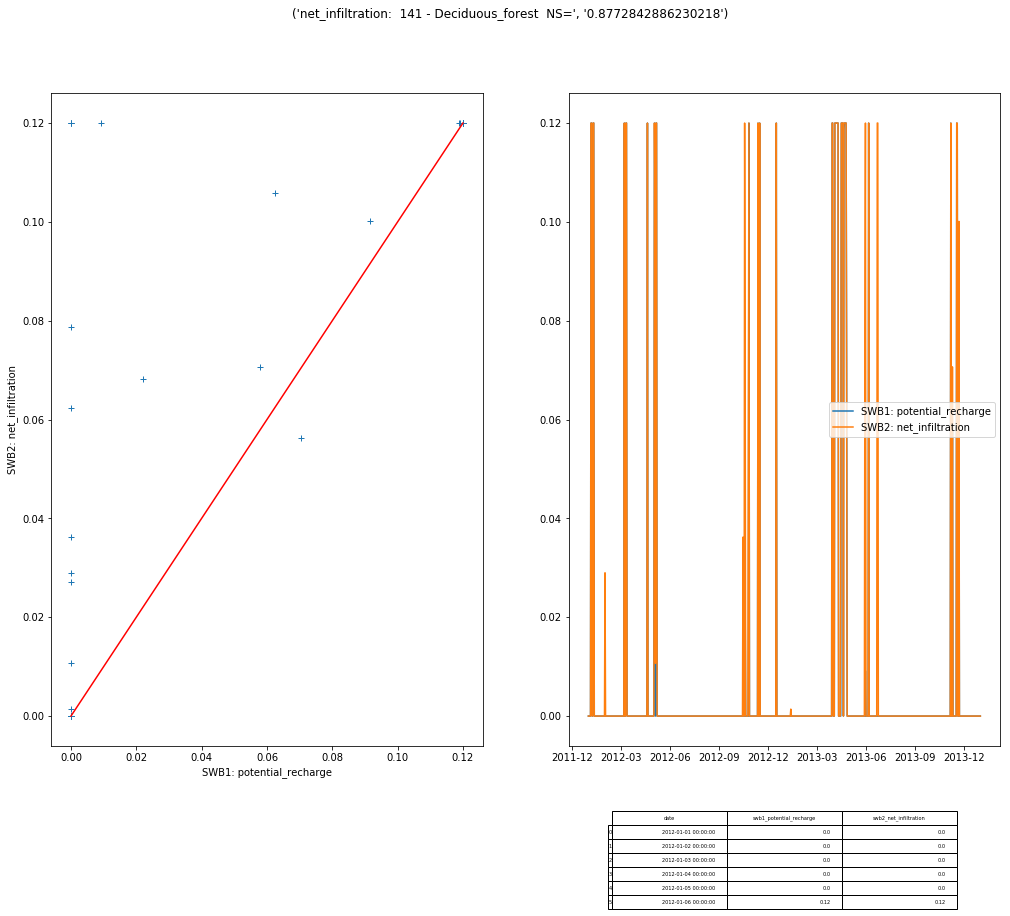

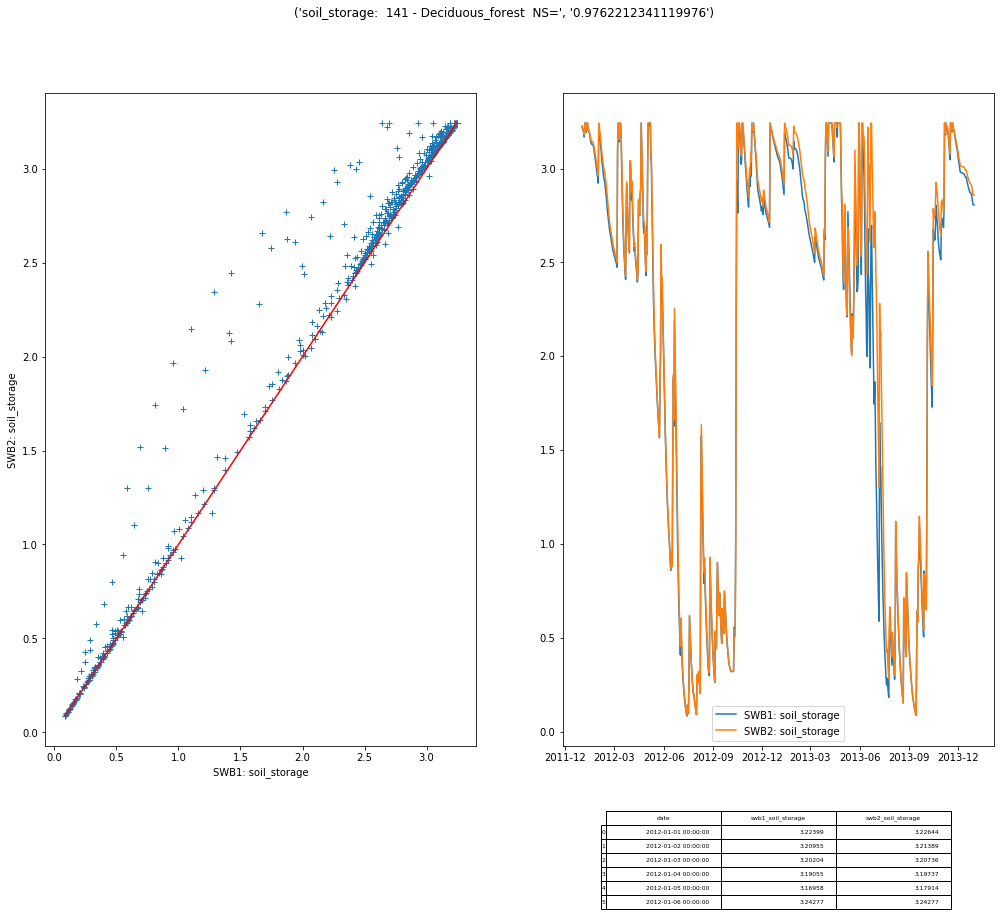

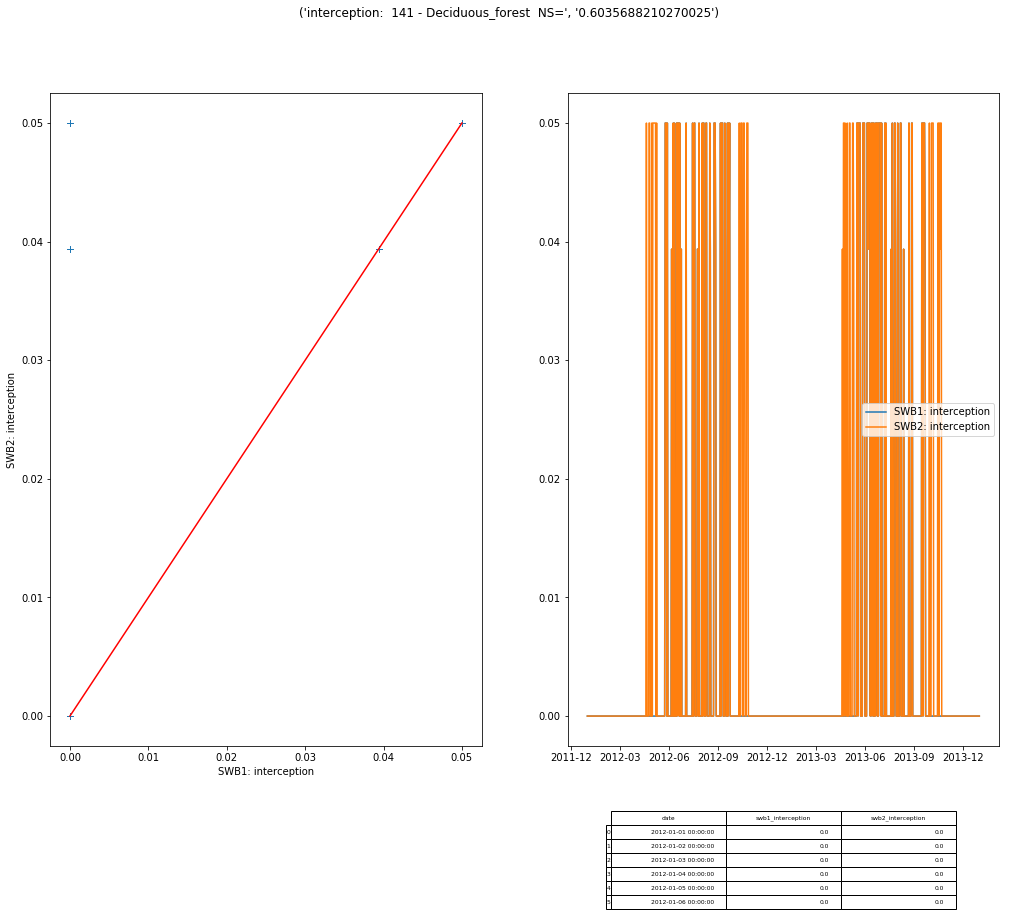

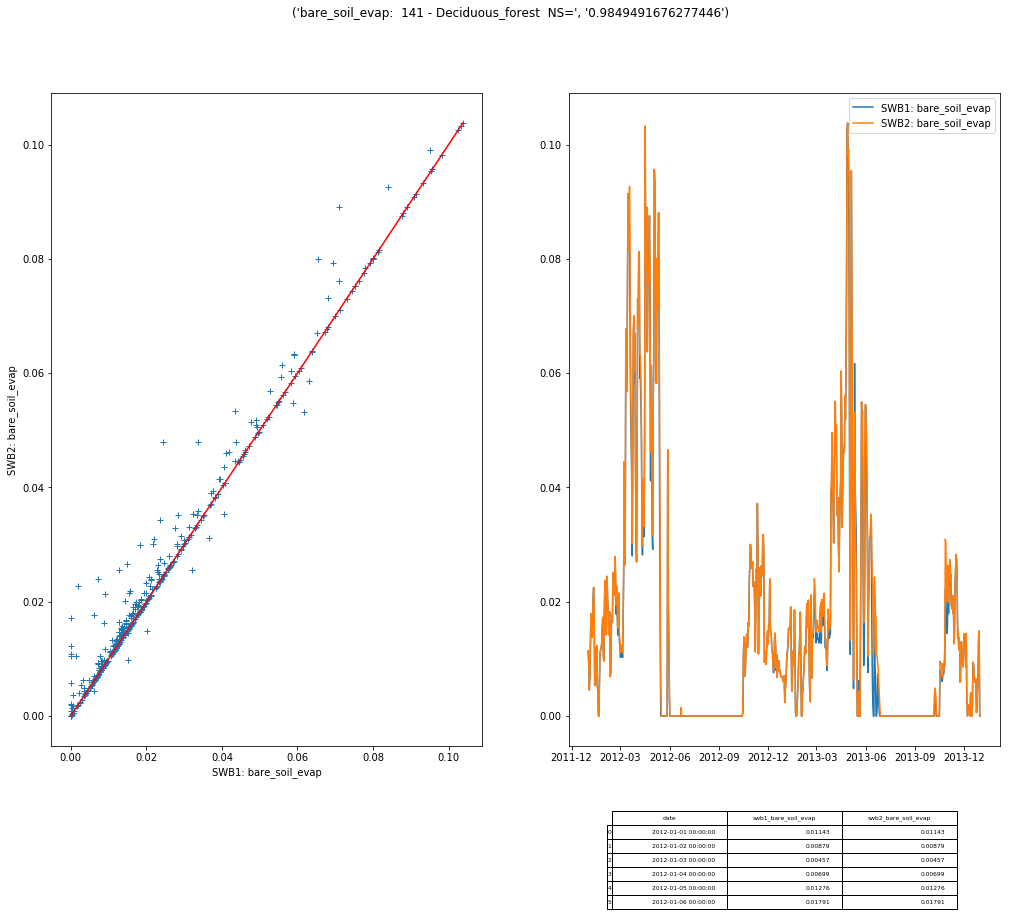

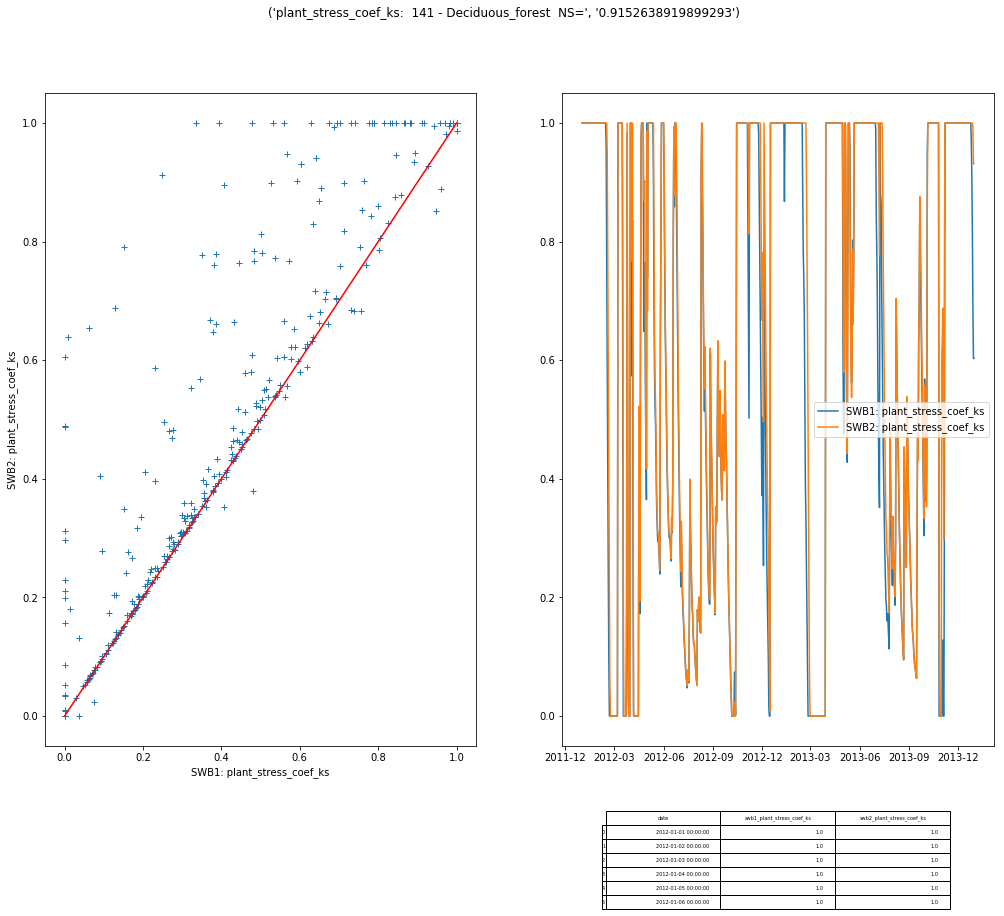

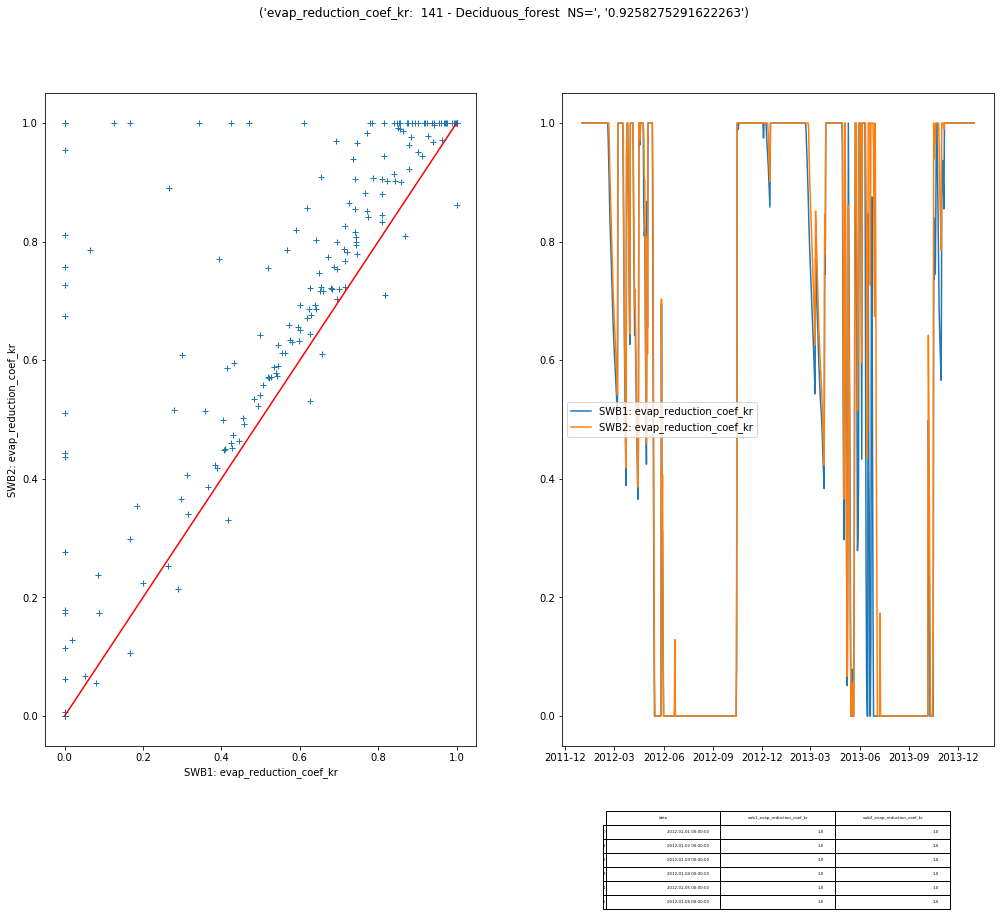

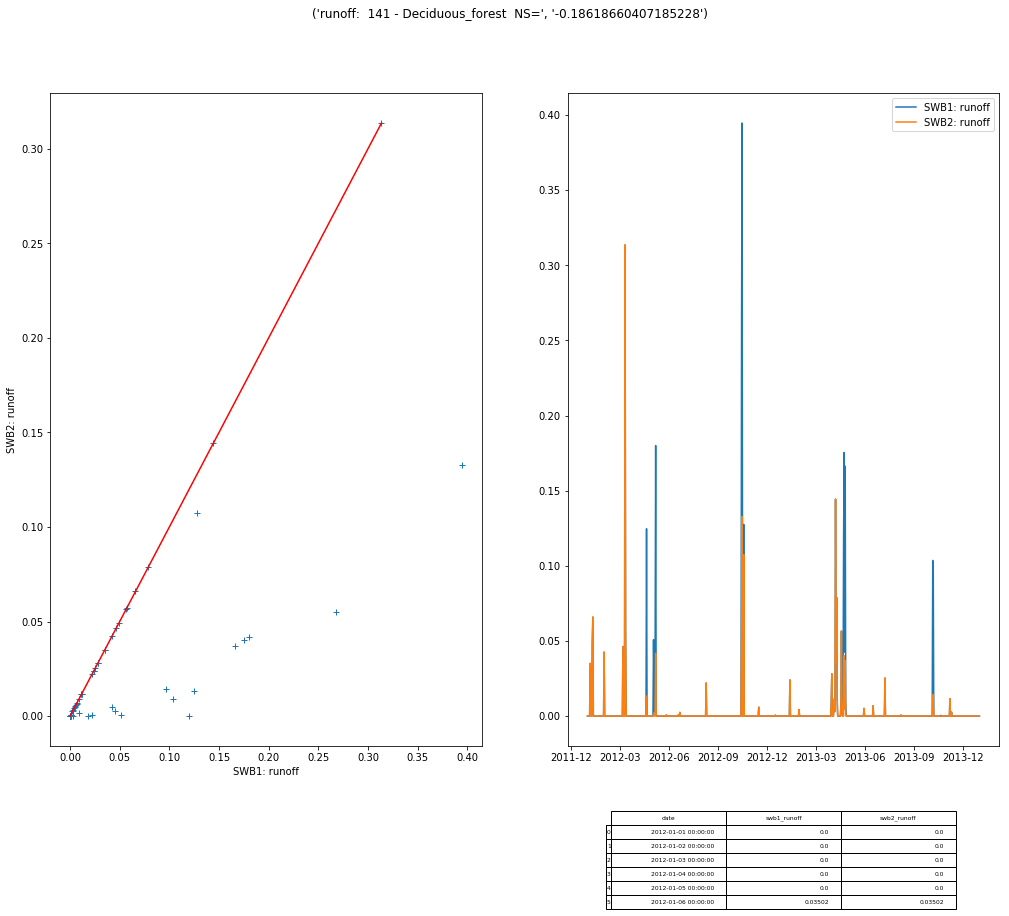

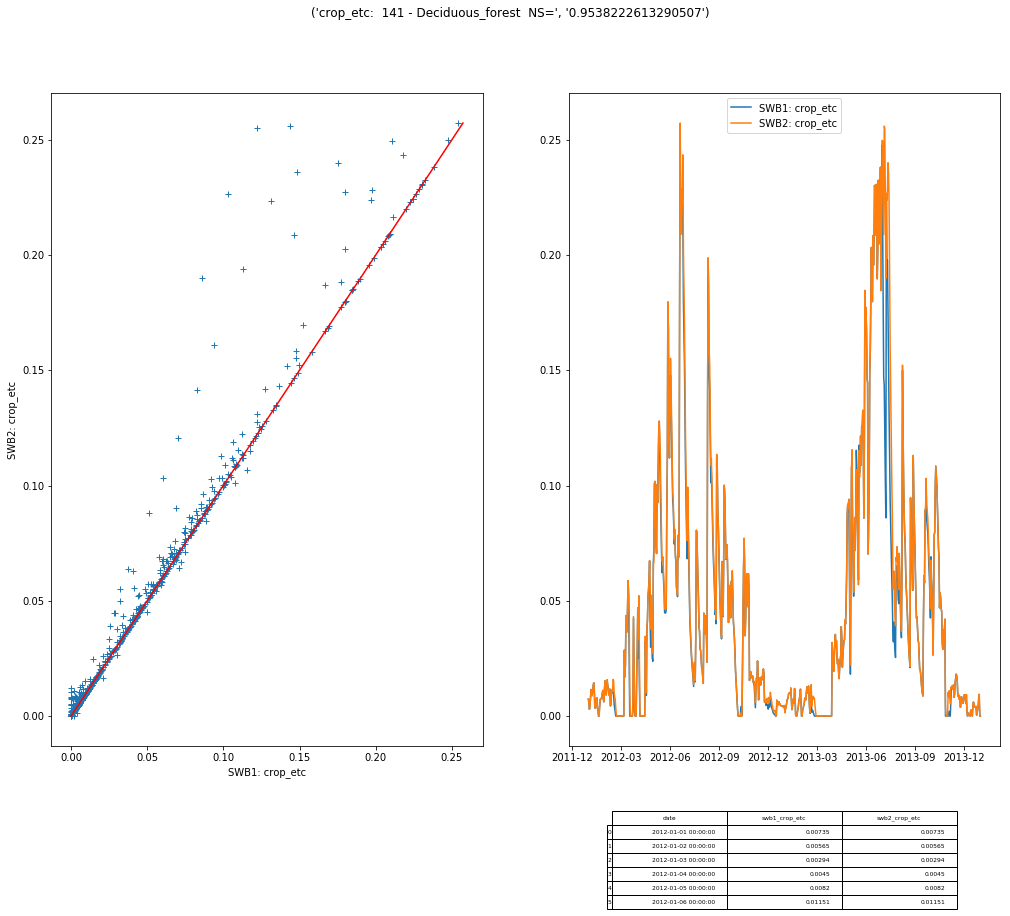

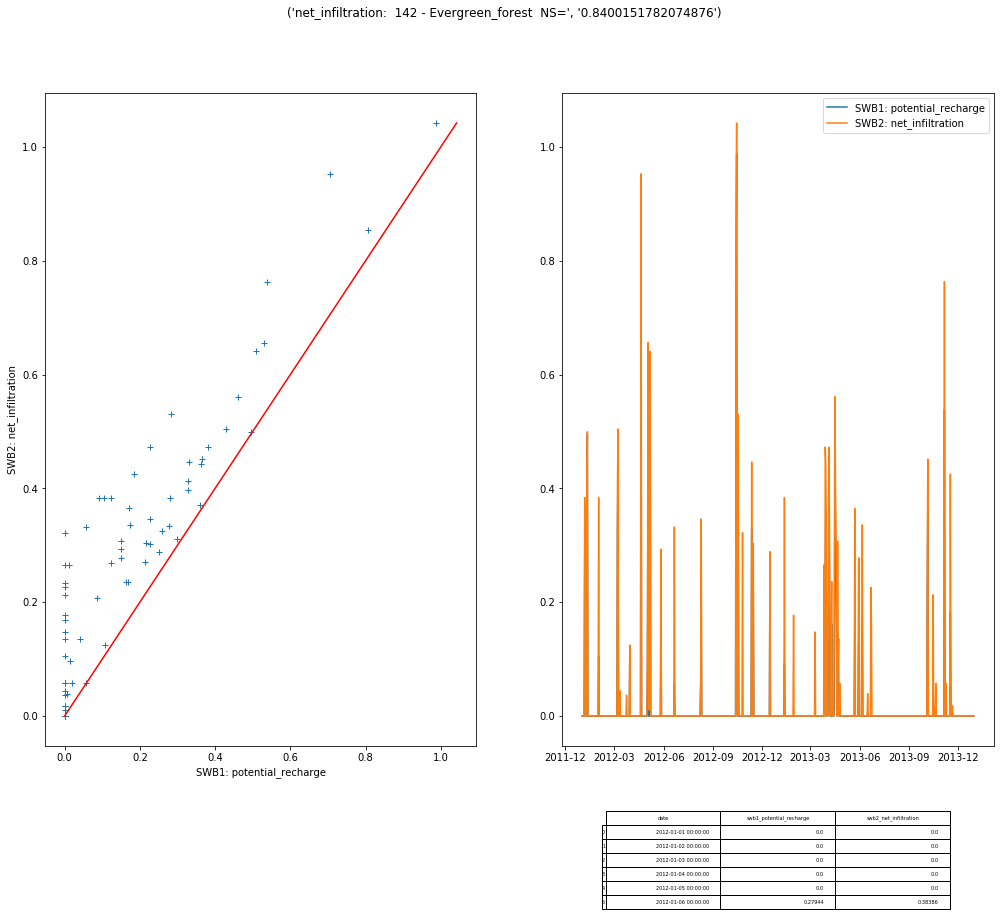

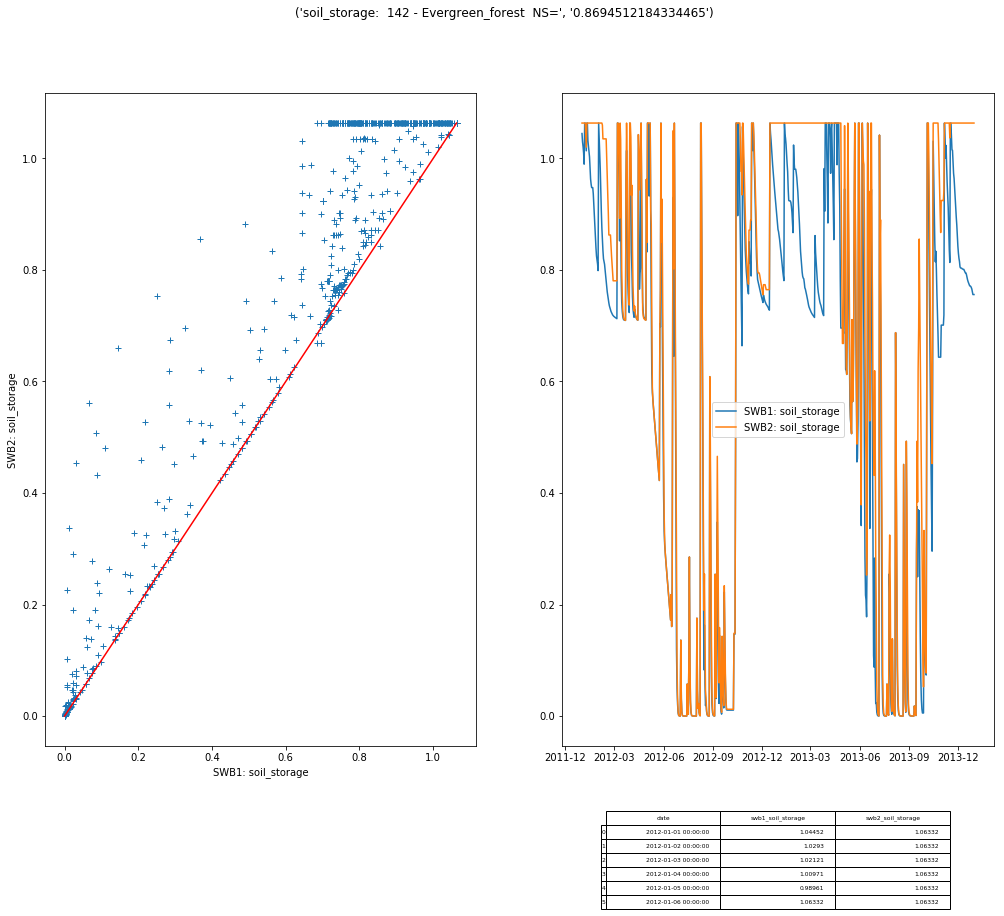

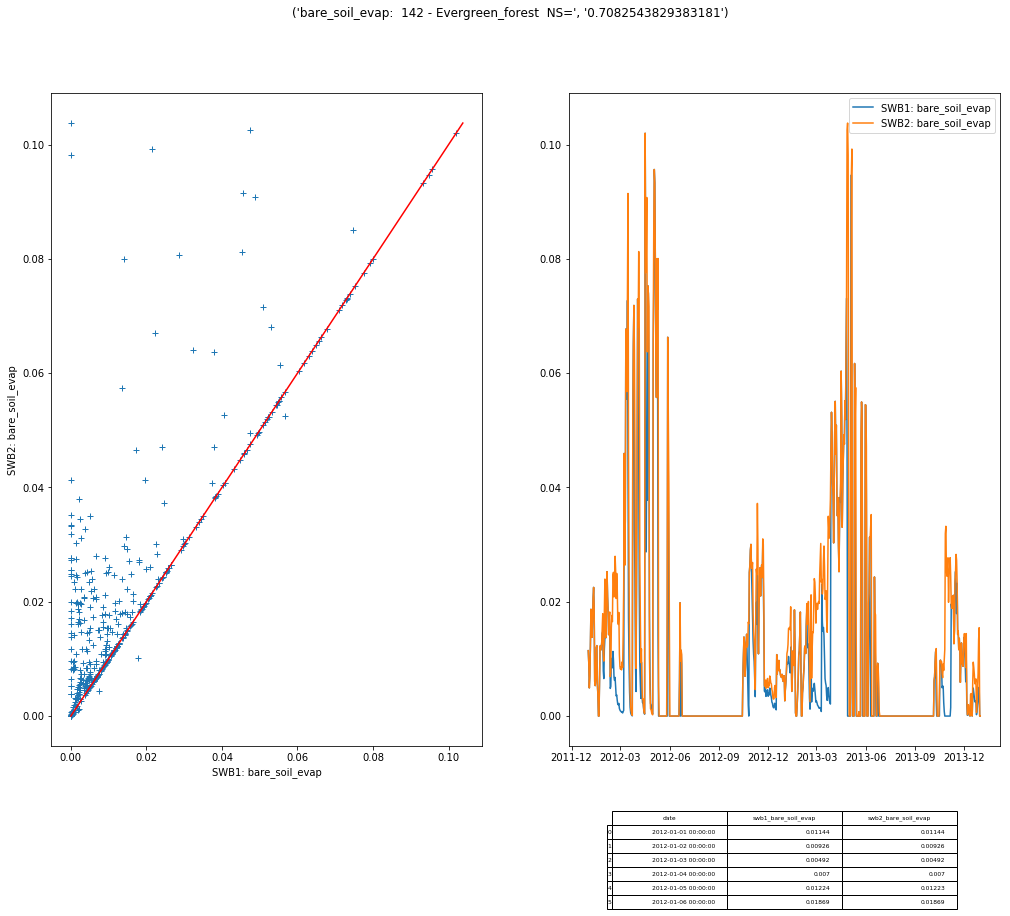

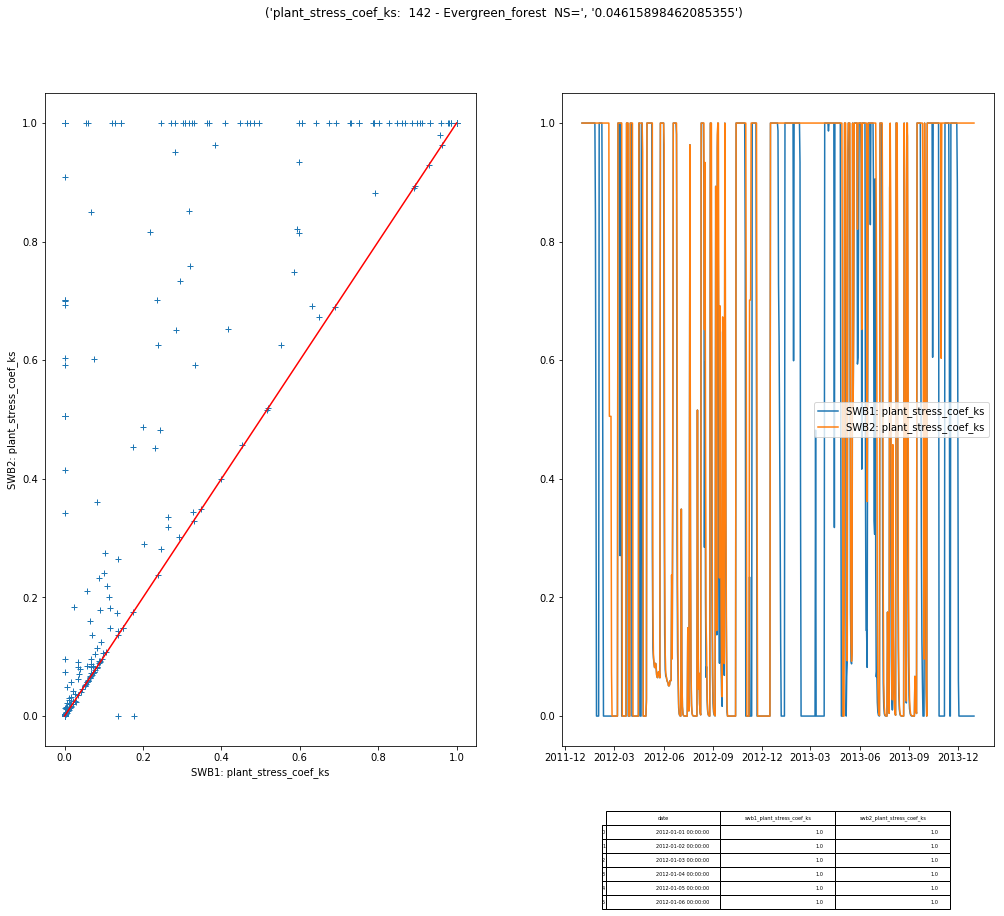

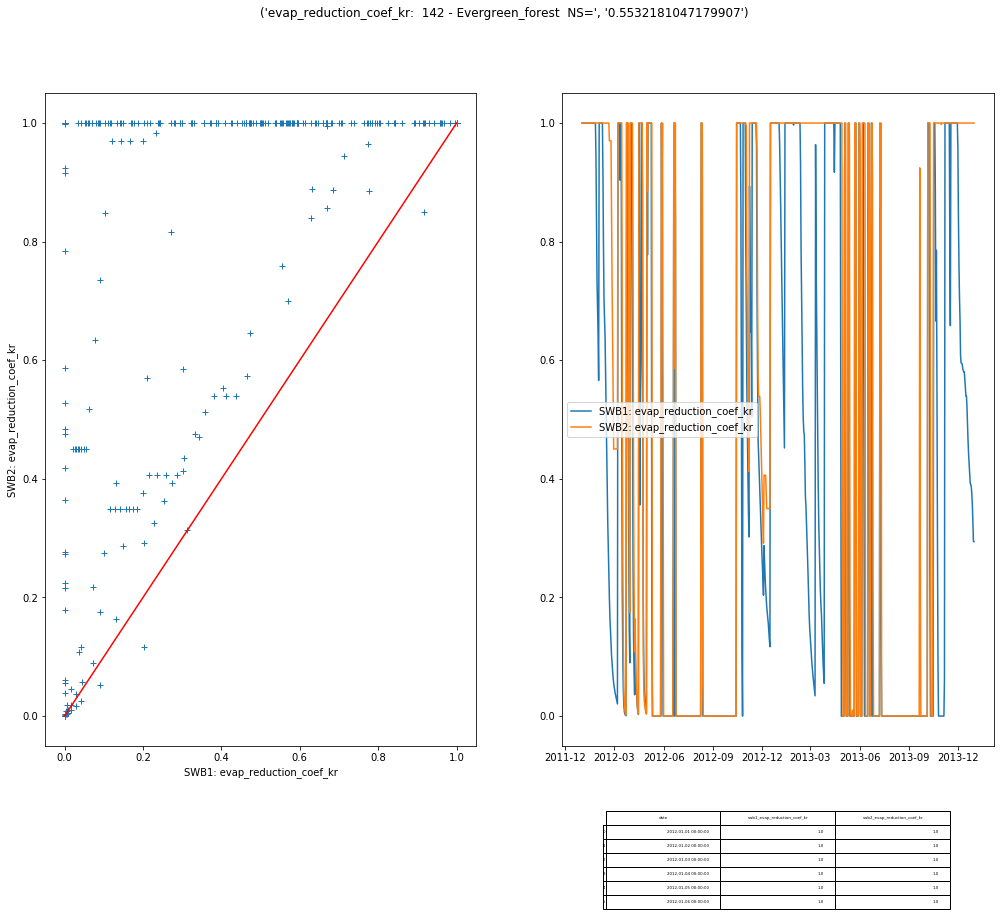

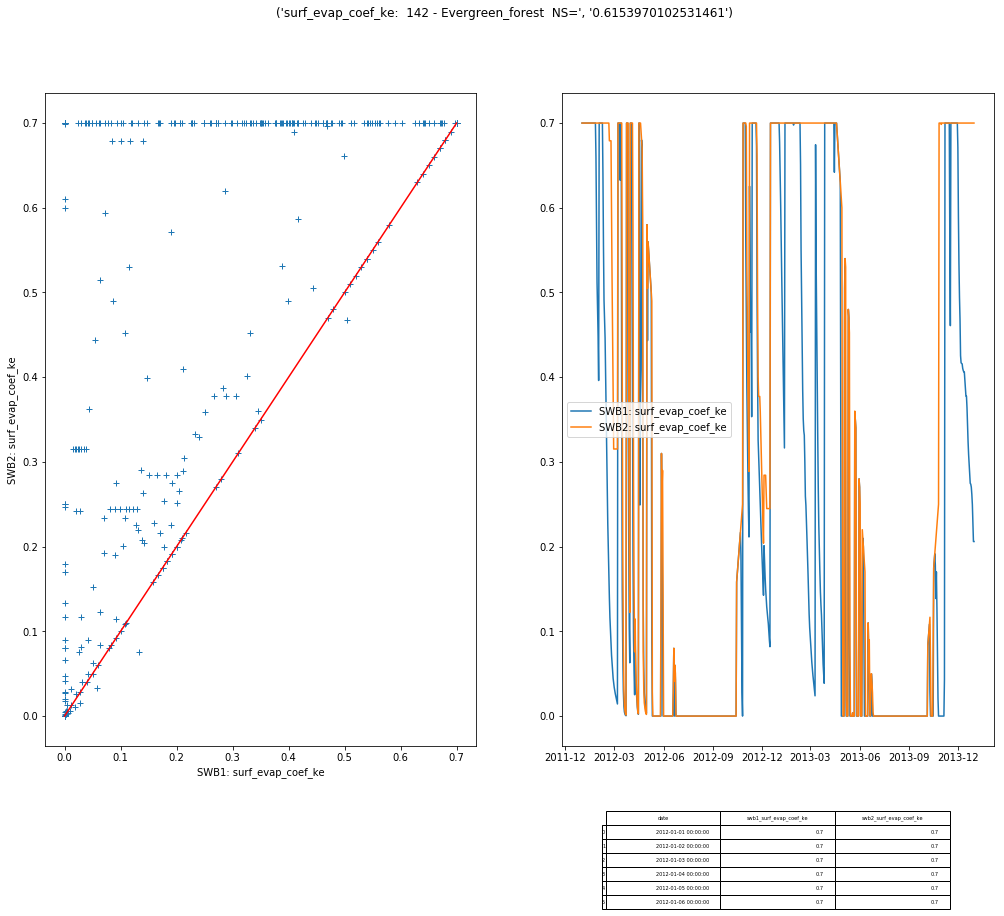

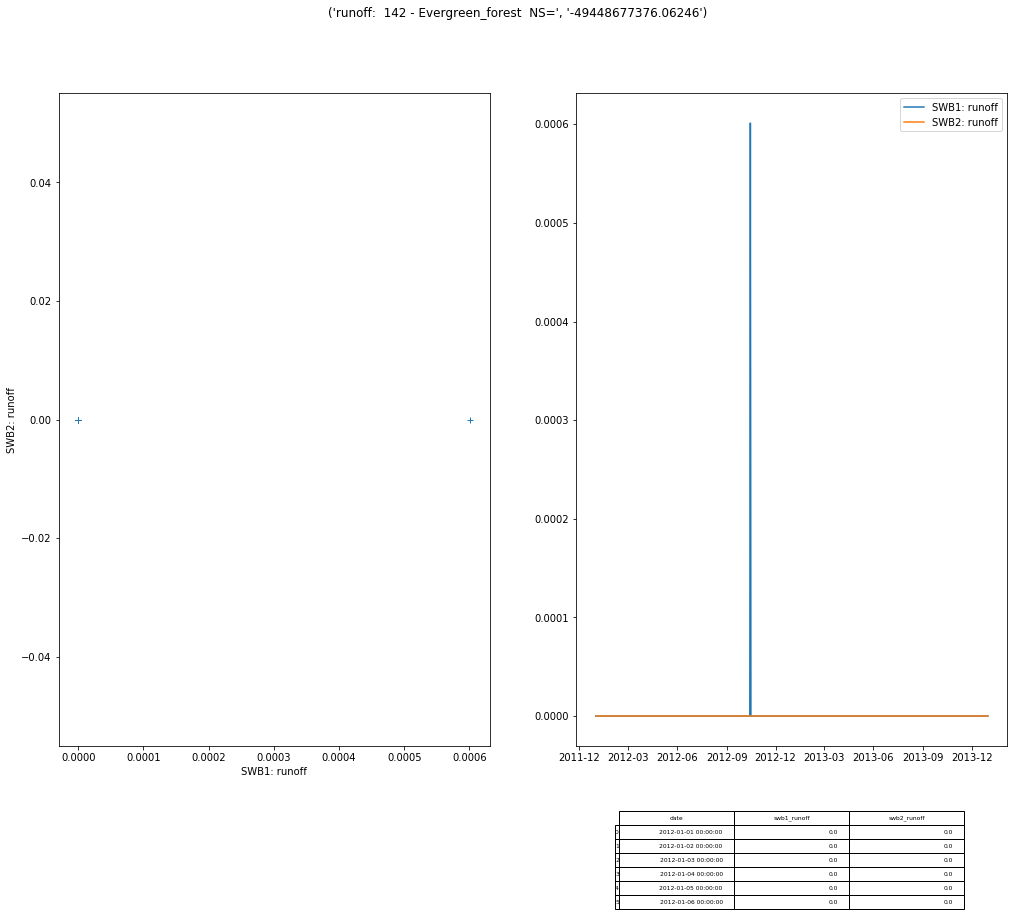

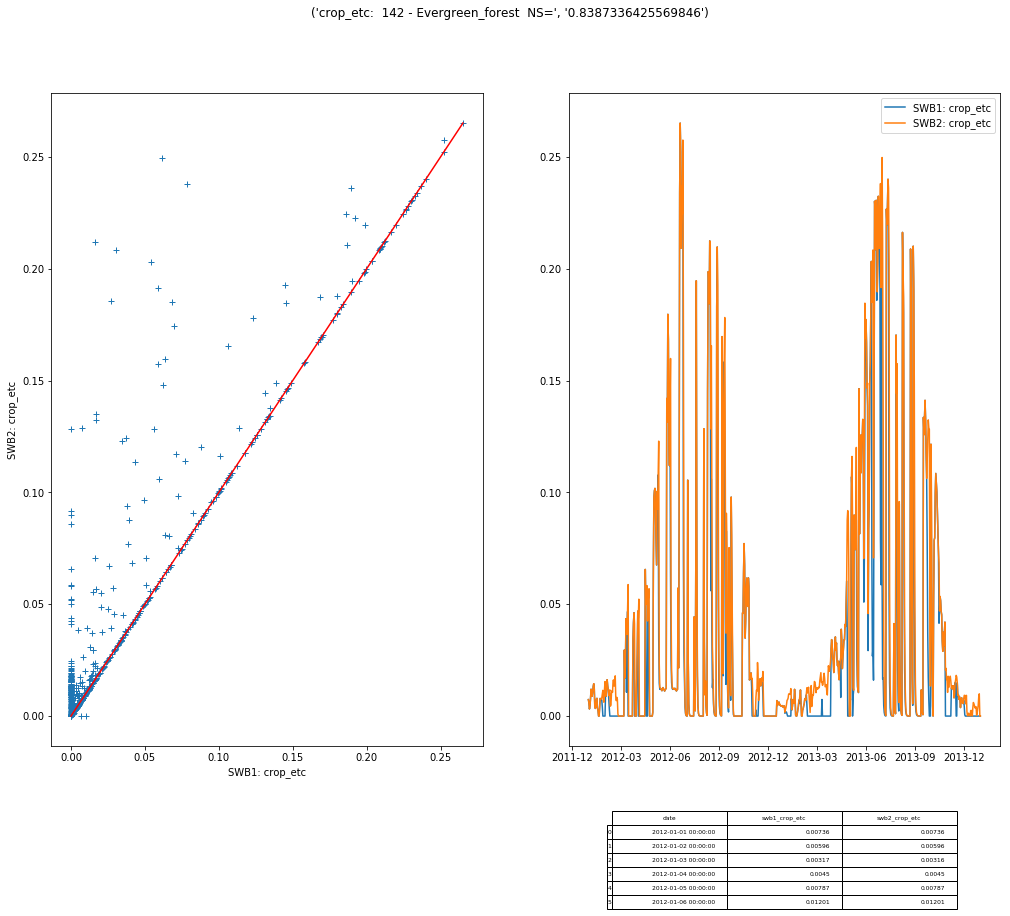

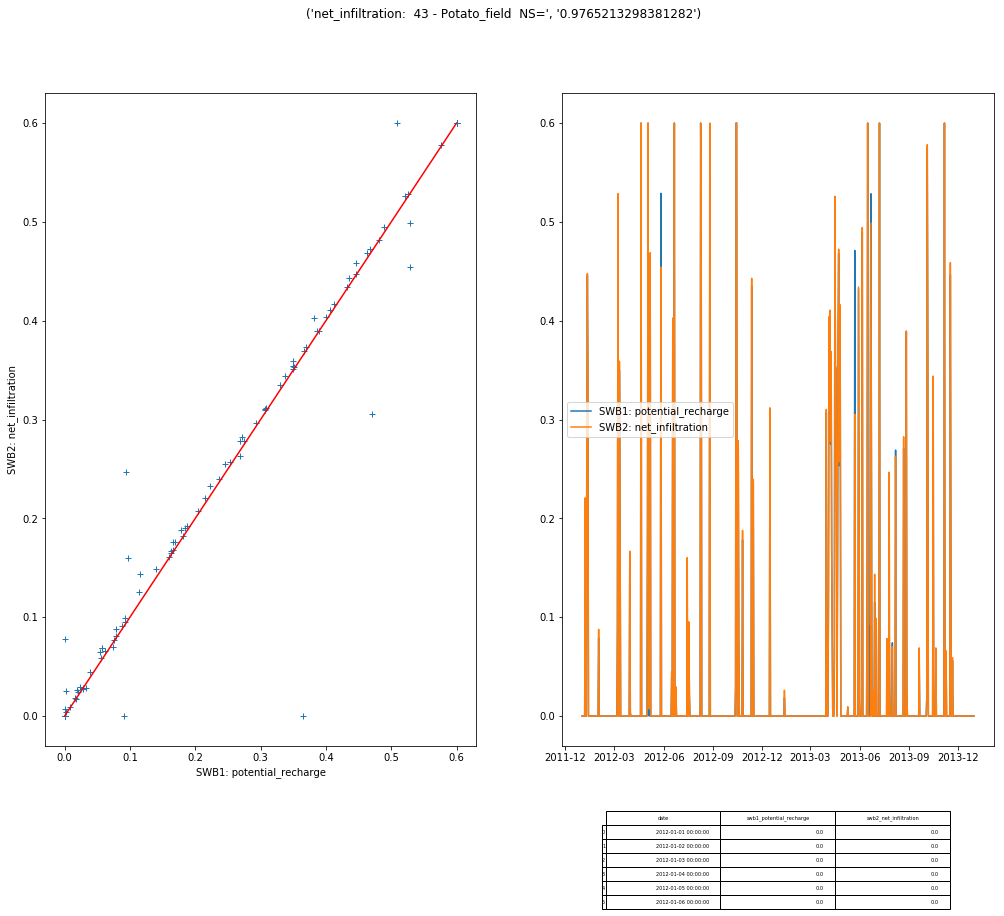

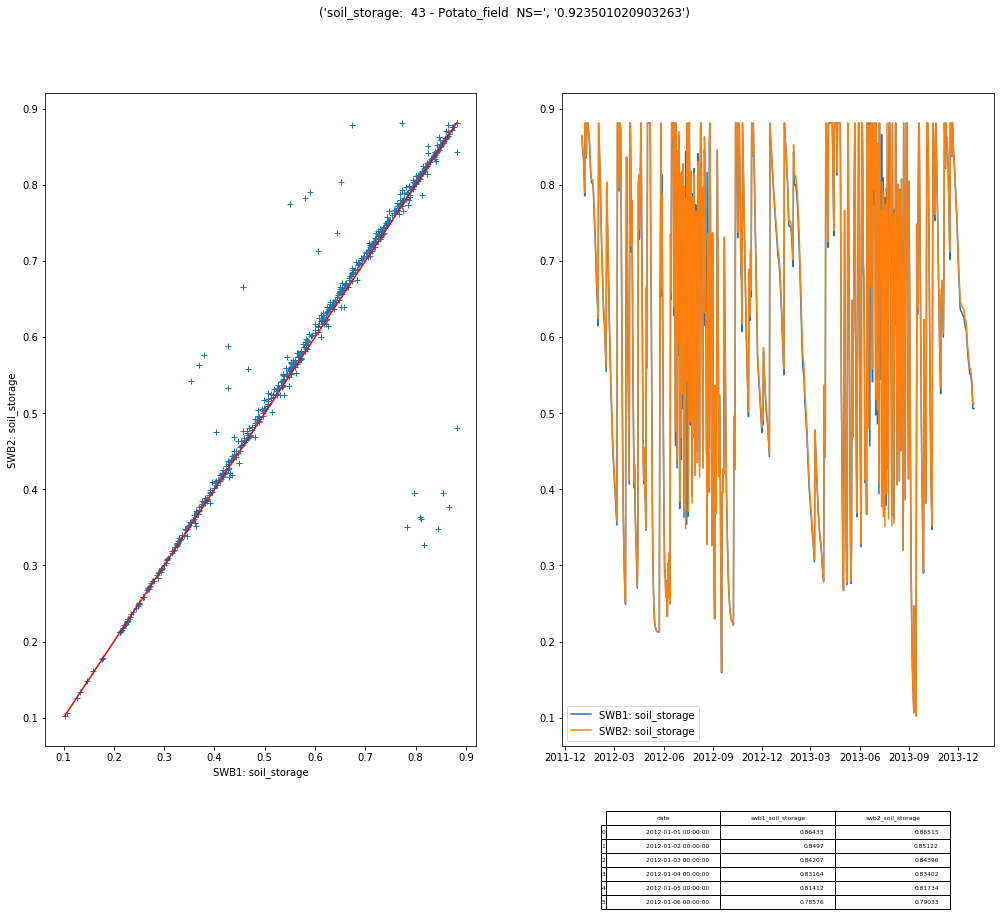

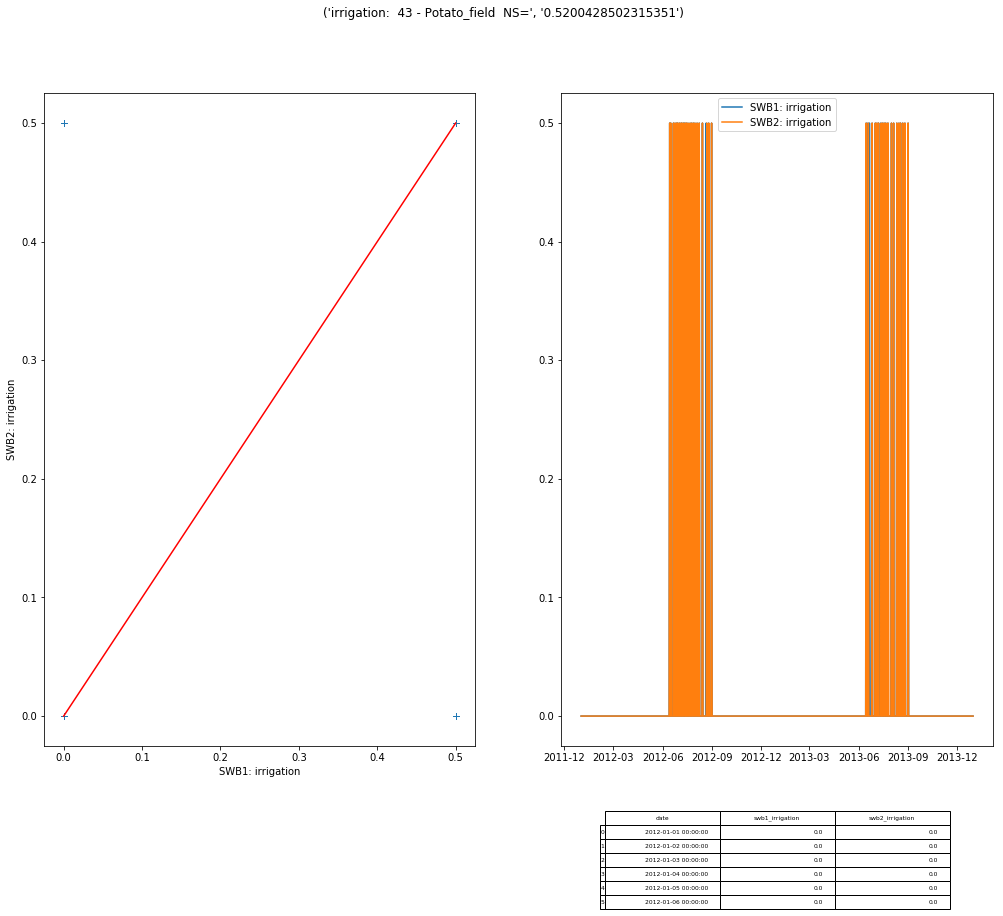

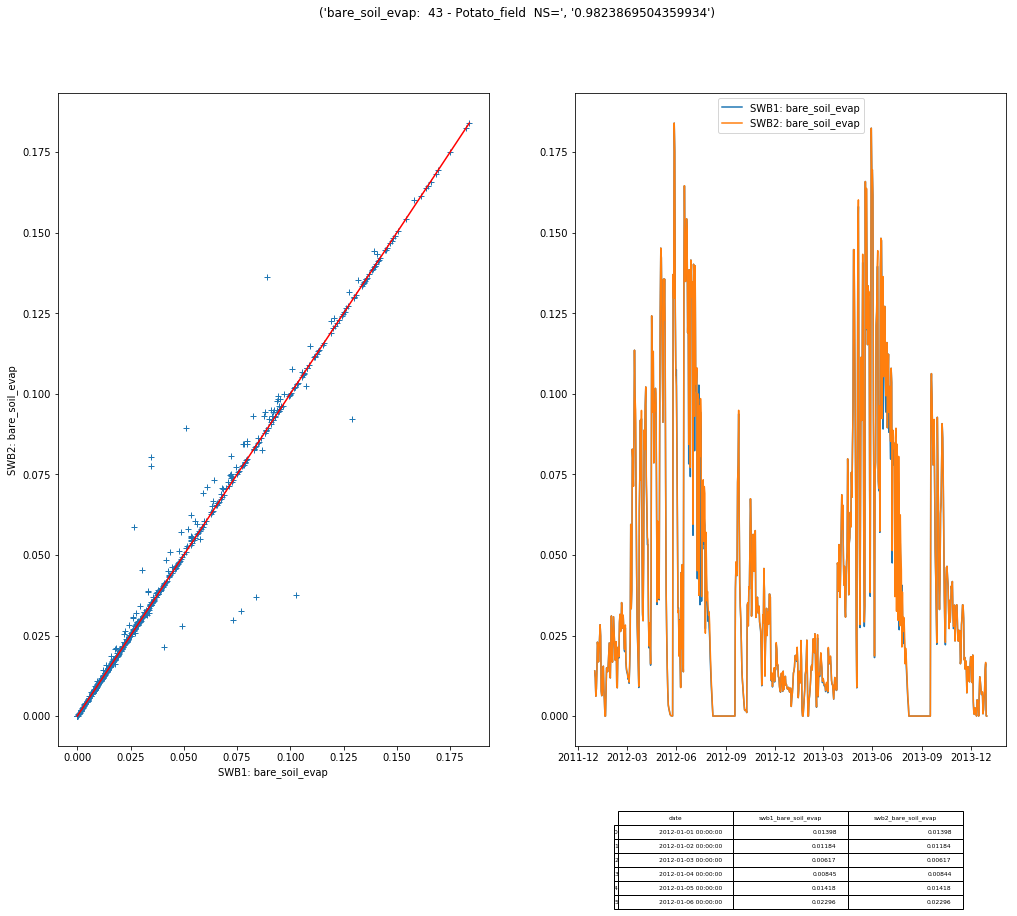

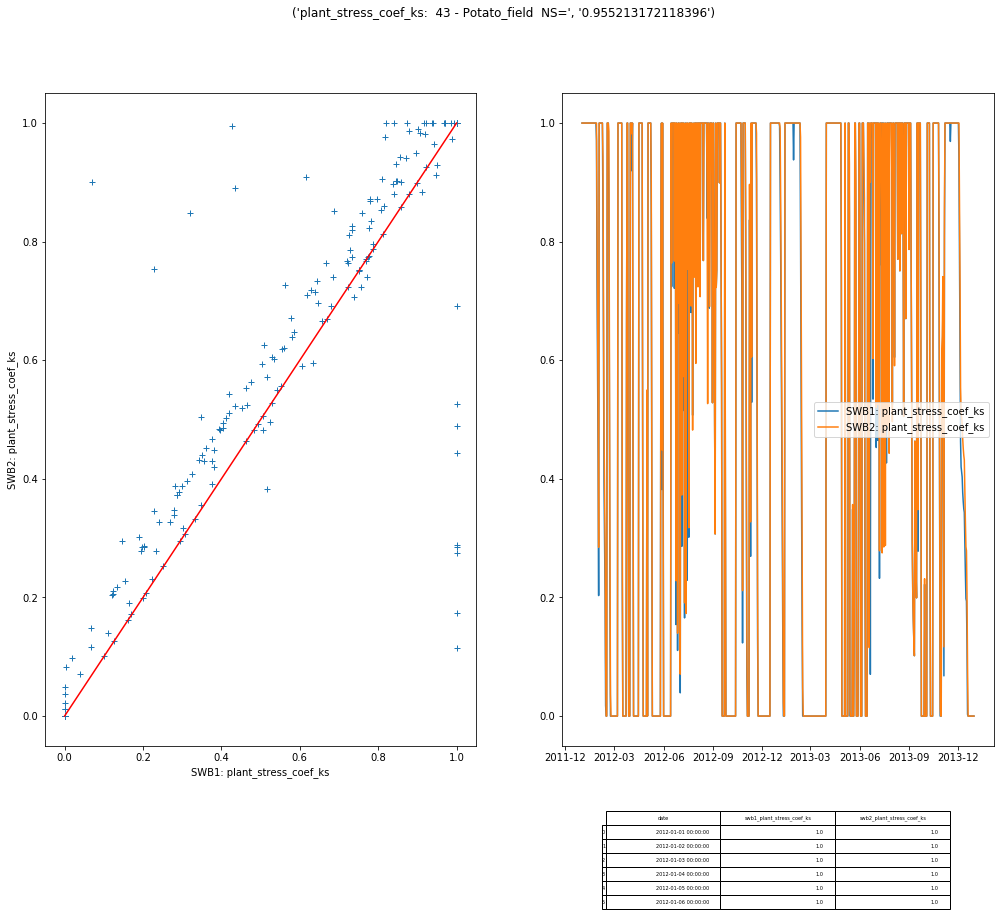

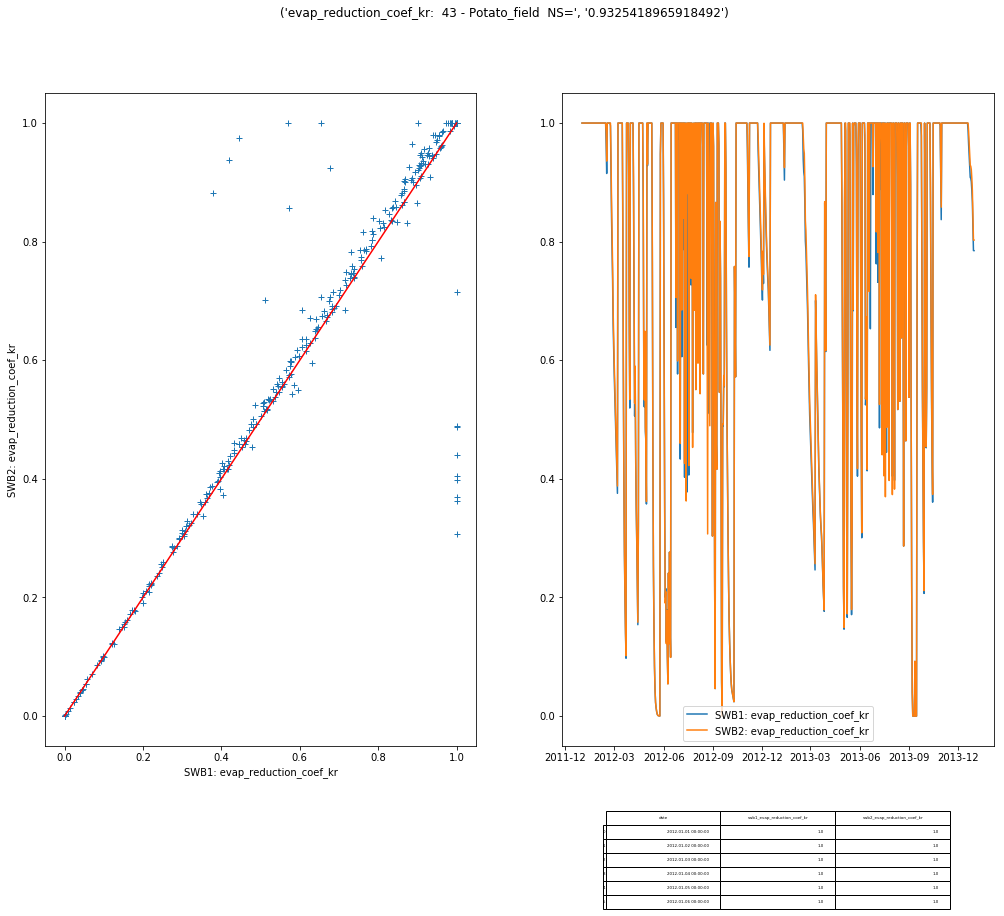

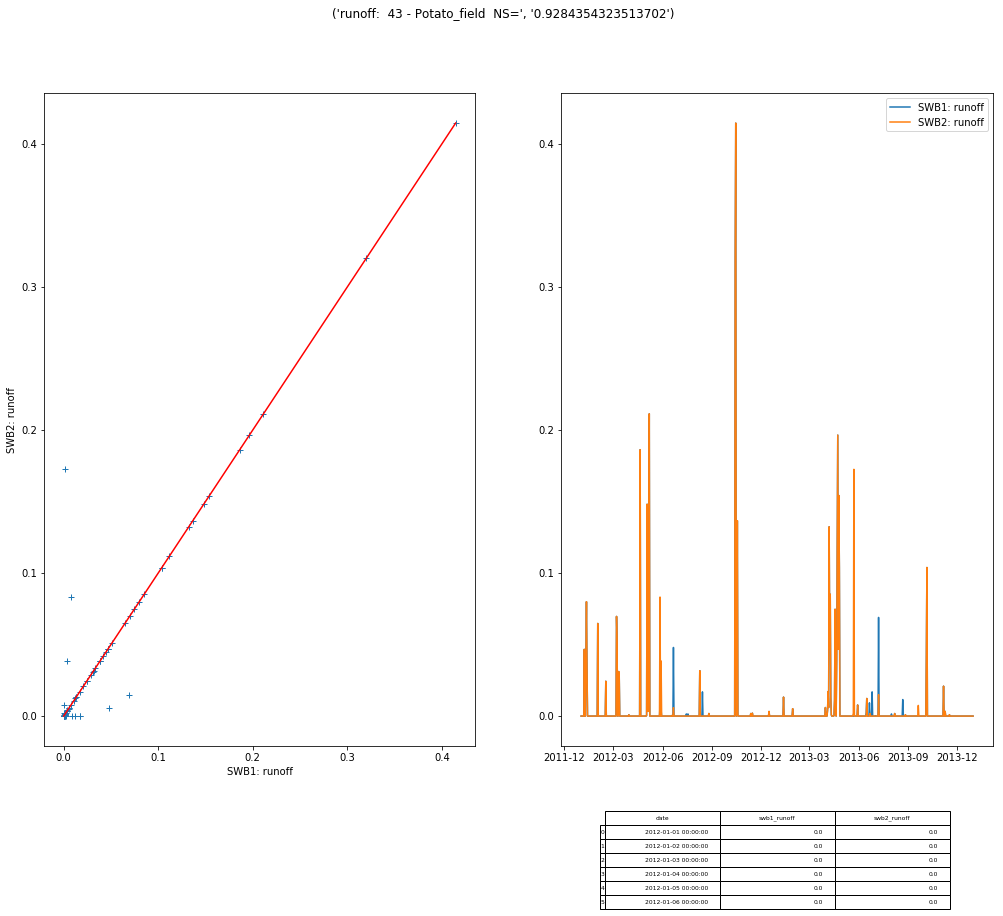

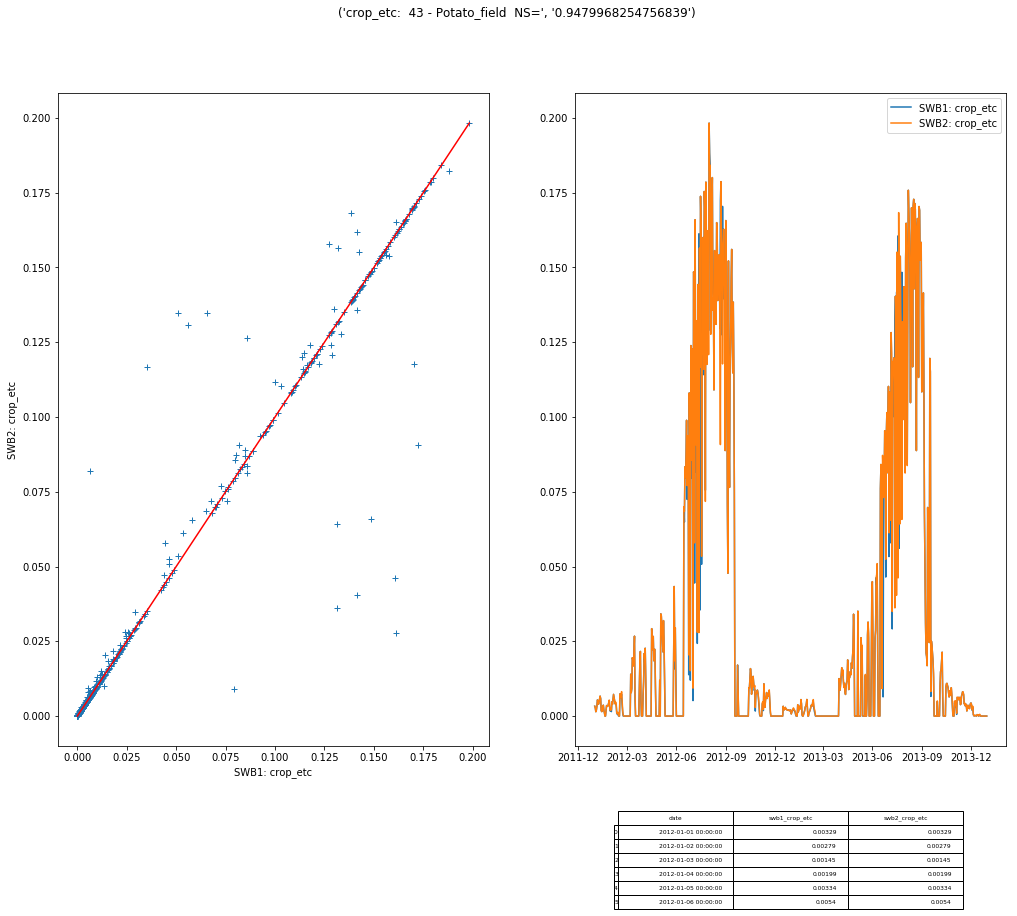

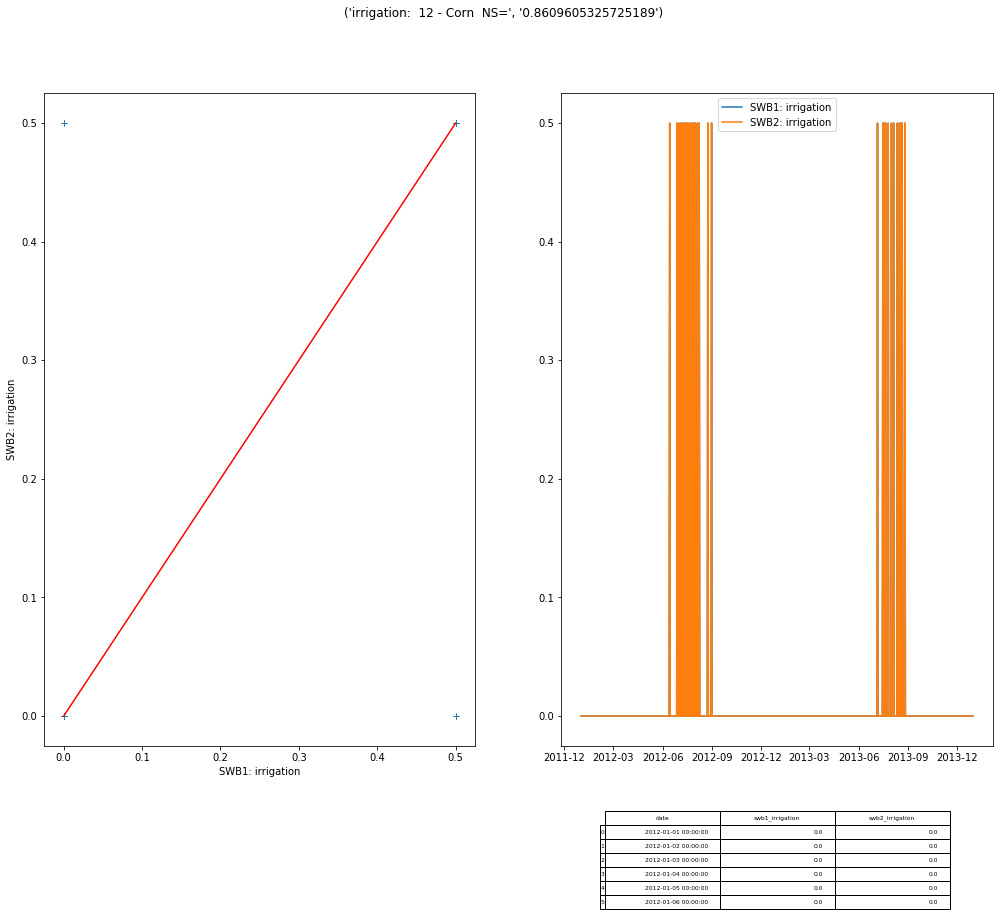

In [41]:
variable_pairs = soil_variable_pairs
for description,vals in comparison_cell_dict.items():
    print(description,vals)
    colnum = vals[0]
    rownum = vals[1]
    xcoord = vals[2]
    ycoord = vals[3]
    swb1_df = read_swb1_csv( colnum, rownum )
#    swb1_df = swb1_df.loc[swb1_df['date'].between('2012-12-01', '2013-03-31')]
    swb2_df = read_swb2_csv( colnum, rownum, xcoord, ycoord )
    swb2_df['gross_precip'] = swb2_df['rainfall'] + swb2_df['snowfall']
    make_plots( swb1_df, swb2_df, description )